In [8]:
from flash_ansr import FlashANSR, install_model, get_path
 
import torch
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
from drawdata import ScatterWidget

In [3]:
MODEL = "psaegert/flash-ansr-v7.0"

In [4]:
install_model(MODEL)

Installing model psaegert/flash-ansr-v7.0 to /home/psaegert/Projects/flash-ansr/models/psaegert/flash-ansr-v7.0


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

Model psaegert/flash-ansr-v7.0 installed successfully!


In [10]:
nsr = FlashANSR.load(
    directory=get_path('models', MODEL),
    beam_width=256,
    n_restarts=32,
    verbose=True,
    numeric_head=False
).to(device)

In [11]:
widget = ScatterWidget()
widget

ScatterWidget()

In [12]:
X_raw, y_raw = widget.data_as_X_y

# Scale X_raw and y_raw to (-10, 10)
X = (X_raw - X_raw.min(axis=0)) / (X_raw.max(axis=0) - X_raw.min(axis=0)) * 20 - 10
y = (y_raw - y_raw.min(axis=0)) / (y_raw.max(axis=0) - y_raw.min(axis=0)) * 20 - 10

In [14]:
nsr.fit(X, y, verbose=True)

Fitting Constants: 100%|██████████| 256/256 [00:10<00:00, 24.72it/s]


FlashANSR(beam_width=256,
          expression_space=<flash_ansr.expressions.expression_space.ExpressionSpace object at 0x7f7f1b334950>,
          flash_ansr_transformer=FlashANSRTransformer(
  (pre_encoder): PreEncoder()
  (encoder): SetTransformer(
    (enc): Sequential(
      (0): ISAB(
        (mab0): MAB(
          (W_q): Linear(in_features=512, out_features=512, bias=True)
          (W_k): Linear(in_features=64, out_features...
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=33, bias=True)
  )
  (num_out): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
),
          n_restarts=32, verbose=True)

In [15]:
nsr.get_expression()

'-1.57 * (cos(0.23 * x1) * (2.15 + (x1 + cos(0.9 * x1))))'

In [16]:
X_linspace = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

In [17]:
y_pred = [[nsr.predict(X, nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result[1]['fits'])) if np.isfinite(result[1]['score'])] for beam_id, result in enumerate(nsr._results)]
y_pred_linspace = [[nsr.predict(X_linspace, nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result[1]['fits'])) if np.isfinite(result[1]['score'])] for beam_id, result in enumerate(nsr._results)]

In [18]:
y_pred = y_pred[:32]
y_pred_linspace = y_pred_linspace[:32]

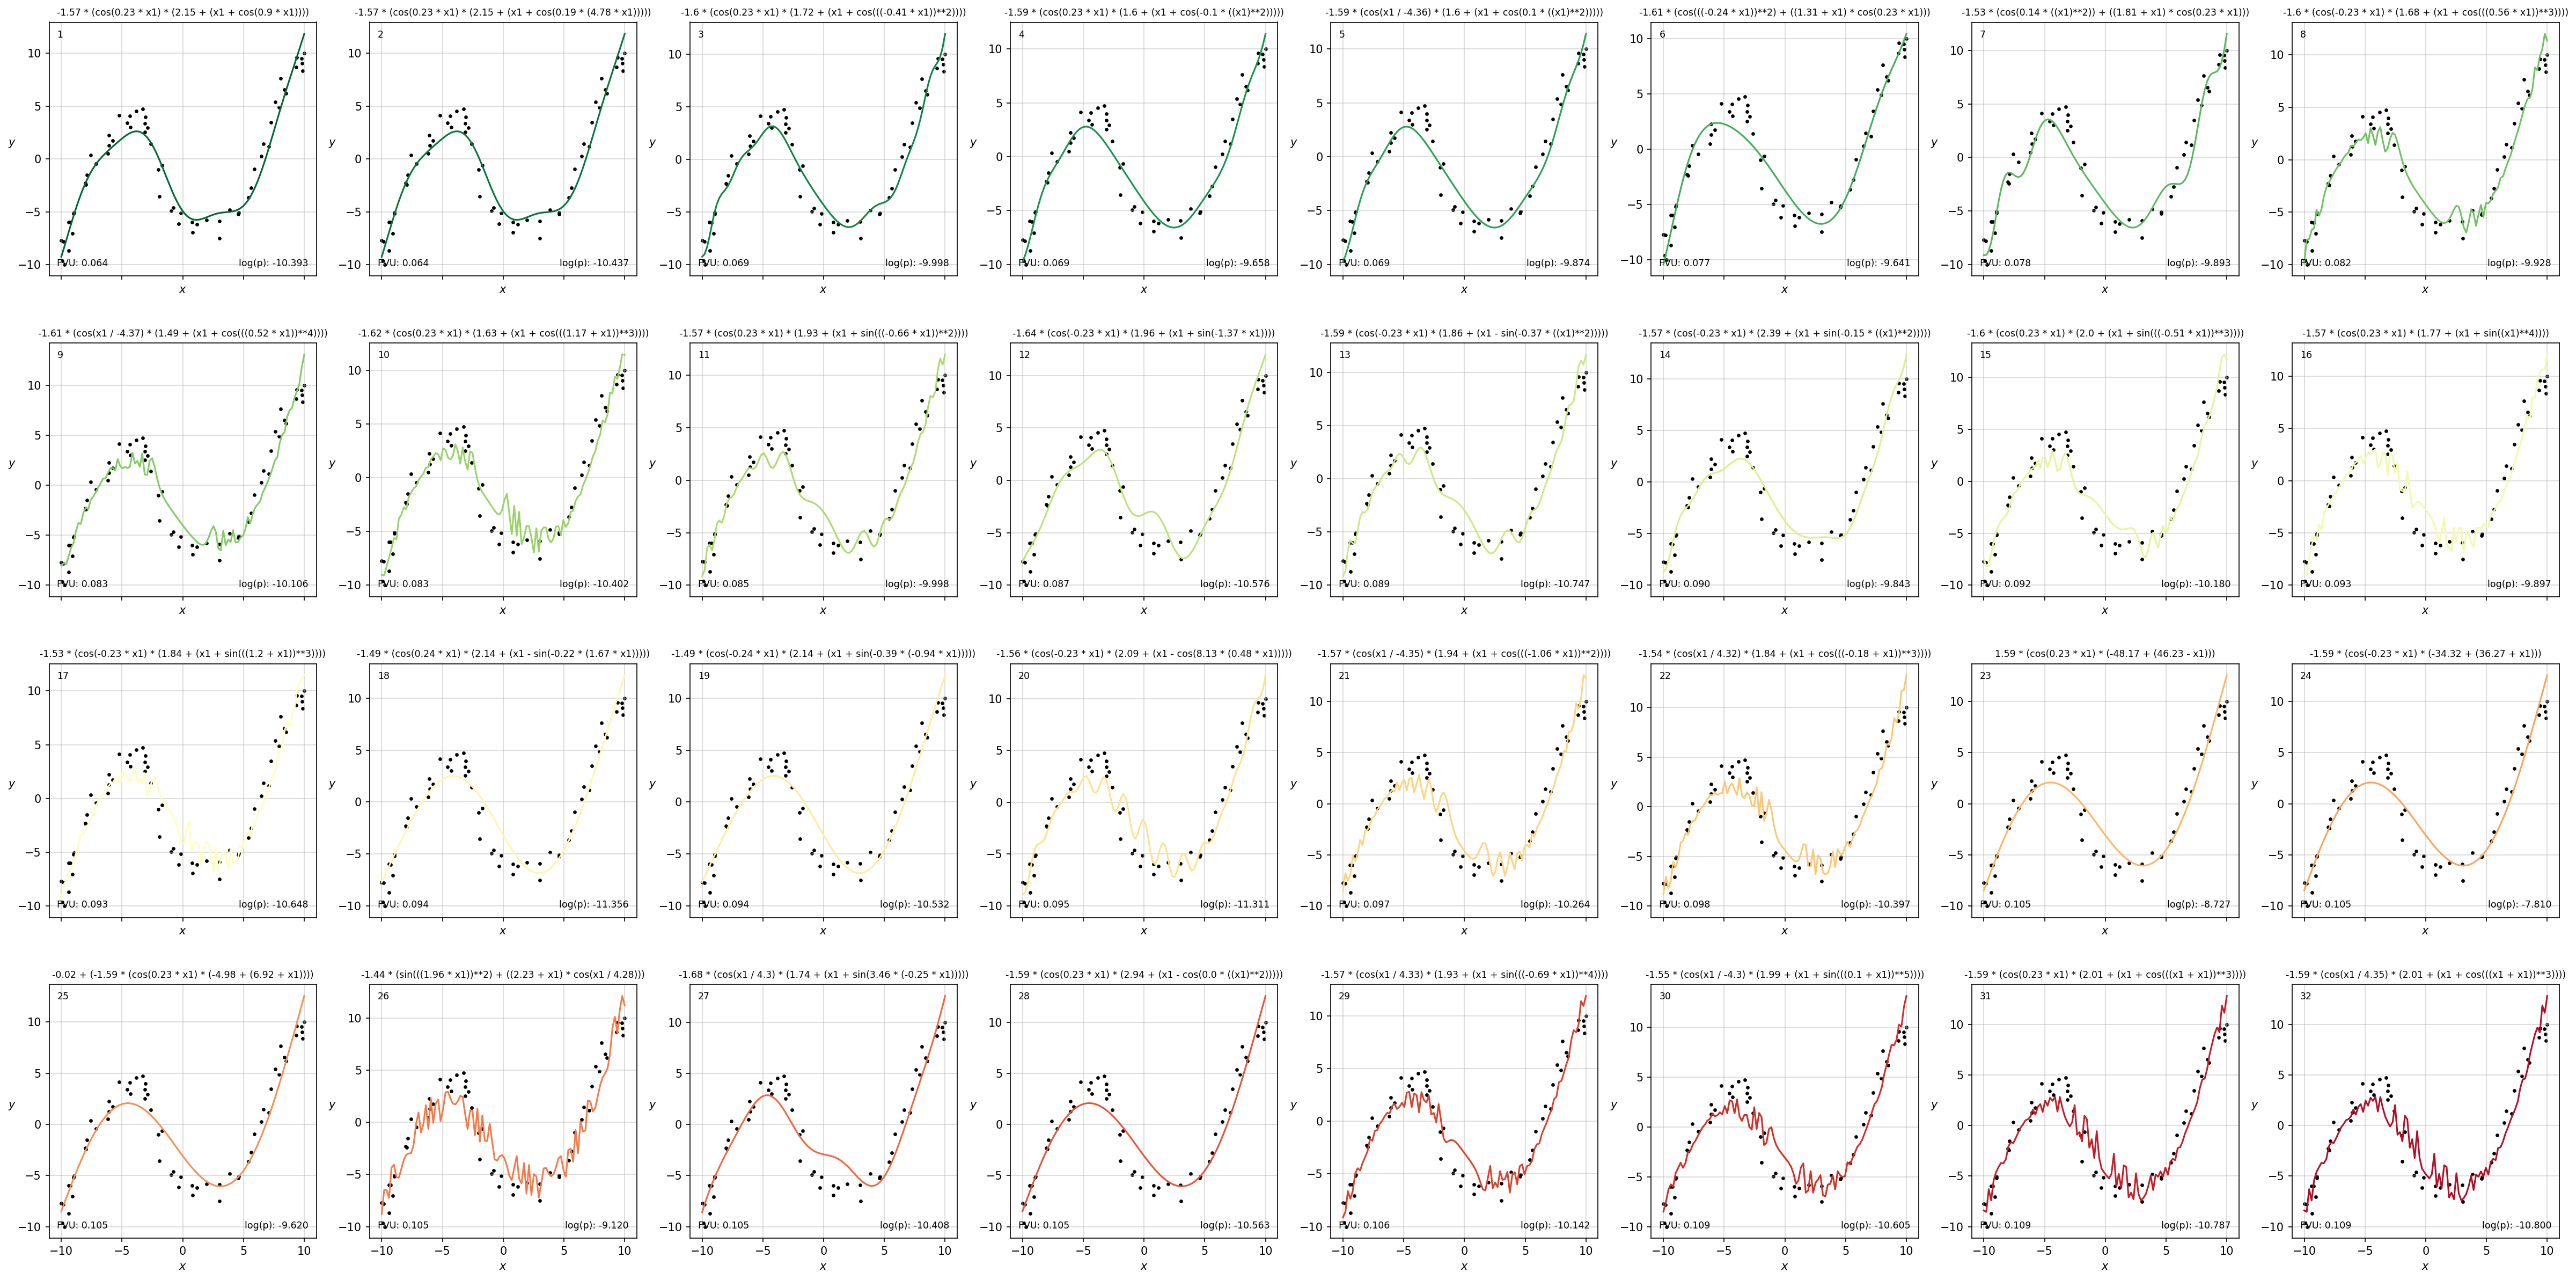

In [19]:
COLS = 8
ROWS = np.ceil(len(y_pred) / COLS).astype(int)

fig, axs = plt.subplots(ROWS, COLS, figsize=(COLS * 4, ROWS * 4), dpi=150, sharex=True)

for i, ax in enumerate(axs.flat):
    if i >= len(y_pred) or len(y_pred[i]) == 0:
        ax.axis('off')
        continue
    fvu = np.mean((y_pred[i][0][:, 0] - y)**2) / np.var(y)
    expression_pred_transformed = nsr._results[i][0].transform(nsr._results[i][1]['expression'], 0, return_prefix=True)
    expression_pred_transformed_infix = nsr.expression_space.prefix_to_infix(expression_pred_transformed, power='**')

    ax.plot(X_linspace, y_pred_linspace[i][0], color=plt.get_cmap('RdYlGn')(1 - i / len(y_pred)))
    ax.scatter(X, y, color='k', s=5)
    ax.set_title(expression_pred_transformed_infix, fontsize='small')
    
    ax.annotate(f'{i + 1}', xy=(0.03, 0.97), xycoords='axes fraction', ha='left', va='top', fontsize='small')
    ax.annotate(f'FVU: {fvu:.3f}', xy=(0.03, 0.03), xycoords='axes fraction', ha='left', va='bottom', fontsize='small')
    ax.annotate(f'log(p): {nsr._results[i][1]["log_prob"]:.3f}', xy=(0.97, 0.03), xycoords='axes fraction', ha='right', va='bottom', fontsize='small')

    ax.grid(alpha=0.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$', rotation=0, labelpad=5)

fig.tight_layout(h_pad=3)